In [430]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import neurokit2 as nk  # Load the package

## Neural kit 2 sample

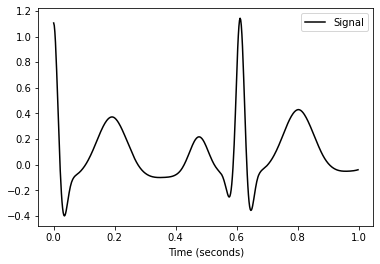

In [431]:
# use neuralkit2 for McSharry equation

simulated_ecg = nk.ecg_simulate(duration=1, sampling_rate=512, heart_rate=100)

nk.signal_plot(simulated_ecg, sampling_rate=512, color="black") 

## Solve system of ODE

In [432]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

writer = SummaryWriter('runs/mcsharry')

In [433]:
# full connected network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.silu = nn.SiLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.silu(out)
        out = self.l2(out)
        out = self.silu(out)
        out = self.l3(out)
        return out

# N is a Neural Network - has 1 hidden layer
Net = NeuralNet(1, 50, 3).to(device)

SyntaxError: invalid syntax (4127980370.py, line 19)

In [ ]:
def derivative(func, input):
    jac = jacobian(func, input)

    i = np.arange(len(input))
    return jac[i, :, i].reshape((len(input), 3))

## McSharry equation

In [ ]:
import math
import numpy as np
import pandas as pd
import scipy


In [ ]:
def signal_resample(
    signal, desired_length=None, sampling_rate=None, desired_sampling_rate=None, method="interpolation"
):
    if desired_length is None:
        desired_length = int(np.round(len(signal) * desired_sampling_rate / sampling_rate))

    # Sanity checks
    if len(signal) == desired_length:
        return signal

    resampled = _resample_interpolation(signal, desired_length)

    return resampled


# =============================================================================
# Methods
# =============================================================================
def _resample_interpolation(signal, desired_length):
    resampled_signal = scipy.ndimage.zoom(signal, desired_length / len(signal))
    return resampled_signal

In [ ]:
# =============================================================================
# ECGSYN
# =============================================================================
def _ecg_simulate_ecgsyn(
    sfecg=256,
    N=256,
    Anoise=0,
    hrmean=60,
    hrstd=1,
    lfhfratio=0.5,
    sfint=512.0,
    ti=(-70, -15, 0, 15, 100),
    ai=(1.2, -5, 30, -7.5, 0.75),
    bi=(0.25, 0.1, 0.1, 0.1, 0.4),
):

    if not isinstance(ti, np.ndarray):
        ti = np.array(ti)
    if not isinstance(ai, np.ndarray):
        ai = np.array(ai)
    if not isinstance(bi, np.ndarray):
        bi = np.array(bi)

    ti = ti * np.pi / 180

    # Adjust extrema parameters for mean heart rate
    hrfact = np.sqrt(hrmean / 60)
    hrfact2 = np.sqrt(hrfact)
    bi = hrfact * bi
    ti = np.array([hrfact2, hrfact, 1, hrfact, hrfact2]) * ti

    # Check that sfint is an integer multiple of sfecg
    q = np.round(sfint / sfecg)
    qd = sfint / sfecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = " + str(sfecg) + " and sfint = " + str(sfint) + "."
        )

    # Define frequency parameters for rr process
    # flo and fhi correspond to the Mayer waves and respiratory rate respectively
    flo = 0.1
    fhi = 0.25
    flostd = 0.01
    fhistd = 0.01
 
    # Calculate time scales for rr and total output
    sfrr = 1
    trr = 1 / sfrr
    rrmean = 60 / hrmean
    n = 2 ** (np.ceil(np.log2(N * rrmean / trr)))

    rr0 = _ecg_simulate_rrprocess(flo, fhi, flostd, fhistd, lfhfratio, hrmean, hrstd, sfrr, n)

    # Upsample rr time series from 1 Hz to sfint Hz
    rr = signal_resample(rr0, sampling_rate=1, desired_sampling_rate=sfint)

    # Make the rrn time series
    dt = 1 / sfint
    rrn = np.zeros(len(rr))
    tecg = 0
    i = 0
    while i < len(rr):
        tecg += rr[i]
        ip = int(np.round(tecg / dt))
        rrn[i:ip] = rr[i]
        i = ip
    Nt = ip

    # Intial condition
    x0 = torch.tensor([1.0, 0.0, 0.04])

    # data range
    # t = torch.Tensor(np.linspace(0, (Nt - 1) * dt, int(Nt/10))[:, None])
    t = torch.Tensor(np.linspace(0, (Nt - 1) * dt, int(Nt/10))[:, None])

    # =============================================================================
    # ODE solver by PINNs
    # =============================================================================
    # loss(t, rrn, torch.tensor(ti), sfint, torch.tensor(ai), torch.tensor(bi), x0)

    # Optimize
    optimizer = torch.optim.Adam(Net.parameters(), lr=0.01) 

    n_epoch = 500
    # traning loop
    for epoch in range(n_epoch):
        optimizer.zero_grad()

        # forward
        l = loss(t, rrn, torch.tensor(ti), sfint, torch.tensor(ai), torch.tensor(bi), x0, epoch)

        # backward
        l.backward()
        optimizer.step()

        if (epoch+1) % 20 == 0:
            print(f'epoch {epoch+1}, loss = {l.item():.4f}')

    return 0

# =============================================================================
# Loss funtion for PINNs
# =============================================================================
def loss(t, rr, ti, sfint, ai, bi, X0, epoch):
    x, y, z = Net(t).T
    dxdt, dydt, dzdt = derivative(Net, t).T

    ## x, y dimensions
    r0 = 1
    a0 = 1.0 - torch.sqrt(x ** 2 + y ** 2) / r0

    ip = torch.floor(t * sfint).int()
    w0 = torch.tensor(2 * np.pi / rr[torch.minimum(ip, torch.full(ip.size(), len(rr) - 1))]).T

    l_x = torch.mean((dxdt - a0 * x + w0 * y)**2)
    l_y = torch.mean((dydt - a0 * y - w0 * x)**2)
    
    ## z dimension
    ta = torch.atan2(y, x).unsqueeze(1).repeat(1, ti.size()[0])
    ti = ti.repeat(ta.size()[0], 1)

    dti = (ta - ti) - torch.round((ta - ti) / 2 / np.pi) * 2 * np.pi

    ai = ai.repeat(dti.size()[0], 1) 
    bi = bi.repeat(dti.size()[0], 1) 

    fresp = 0.25
    zbase = 0.005 * torch.sin(2 * np.pi * fresp * t).flatten()

    l_z = torch.mean((dzdt + torch.sum(ai * dti * torch.exp(-0.5 * (dti / bi) ** 2), dim = 1) + 1 * (z - zbase))**2)

    # ic = torch.sum((np.array([x[0], y[0], z[0]]) - X0)**2)  # initial conditions

    ############## TENSORBOARD ########################
    if (epoch+1) % 20 == 0:
        writer.add_scalar("total_loss", l_x + l_y + l_z , epoch)
        writer.add_scalar("l_x", l_x, epoch)
        writer.add_scalar("l_y", l_y, epoch)
        writer.add_scalar("l_z", l_z, epoch)
    ###################################################
    
    return l_x + l_y + l_z 

def _ecg_simulate_rrprocess(
    flo=0.1, fhi=0.25, flostd=0.01, fhistd=0.01, lfhfratio=0.5, hrmean=60, hrstd=1, sfrr=1, n=256
):
    w1 = 2 * np.pi * flo
    w2 = 2 * np.pi * fhi
    c1 = 2 * np.pi * flostd
    c2 = 2 * np.pi * fhistd
    sig2 = 1
    sig1 = lfhfratio
    rrmean = 60 / hrmean
    rrstd = 60 * hrstd / (hrmean * hrmean)

    df = sfrr / n
    w = np.arange(n) * 2 * np.pi * df
    dw1 = w - w1
    dw2 = w - w2

    Hw1 = sig1 * np.exp(-0.5 * (dw1 / c1) ** 2) / np.sqrt(2 * np.pi * c1 ** 2)
    Hw2 = sig2 * np.exp(-0.5 * (dw2 / c2) ** 2) / np.sqrt(2 * np.pi * c2 ** 2)
    Hw = Hw1 + Hw2
    Hw0 = np.concatenate((Hw[0 : int(n / 2)], Hw[int(n / 2) - 1 :: -1]))
    Sw = (sfrr / 2) * np.sqrt(Hw0)

    ph0 = 2 * np.pi * np.random.uniform(size=int(n / 2 - 1))
    ph = np.concatenate([[0], ph0, [0], -np.flipud(ph0)])
    SwC = Sw * np.exp(1j * ph)
    x = (1 / n) * np.real(np.fft.ifft(SwC))

    xstd = np.std(x)
    ratio = rrstd / xstd
    return rrmean + x * ratio  # Return RR

In [ ]:
duration=1
length=None 
sampling_rate=512
heart_rate=100
heart_rate_std=1

# Generate number of samples automatically if length is unspecified
if length is None:
    length = duration * sampling_rate
if duration is None:
    duration = length / sampling_rate

# Run appropriate method
approx_number_beats = int(np.round(duration * (heart_rate / 60)))
ecg = _ecg_simulate_ecgsyn(
    sfecg=sampling_rate,
    N=approx_number_beats,
    Anoise=0,
    hrmean=heart_rate,
    hrstd=heart_rate_std,
    lfhfratio=0.5,
    sfint=sampling_rate
)

epoch 20, loss = 0.3654
epoch 40, loss = 0.1298
epoch 60, loss = 0.3676
epoch 80, loss = 0.0693
epoch 100, loss = 0.9999
epoch 120, loss = 0.1105
epoch 140, loss = 0.0656
epoch 160, loss = 0.3289
epoch 180, loss = 1.6993
epoch 200, loss = 0.3088
epoch 220, loss = 0.1250
epoch 240, loss = 0.0259
epoch 260, loss = 0.0064
epoch 280, loss = 0.0036
epoch 300, loss = 0.0026
epoch 320, loss = 0.0021
epoch 340, loss = 0.0017
epoch 360, loss = 0.0055
epoch 380, loss = 2.1322
epoch 400, loss = 1.4670
epoch 420, loss = 0.1019
epoch 440, loss = 0.2633
epoch 460, loss = 0.3170
epoch 480, loss = 0.0471
epoch 500, loss = 0.0099


make plot of loss function

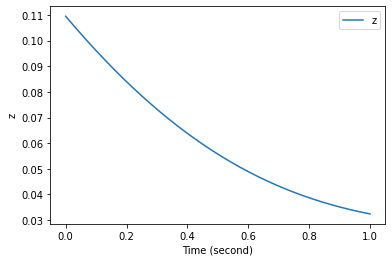

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Let's compare the result to the true solution
xx = np.linspace(0, 2.61, length)[:, None]
with torch.no_grad():
    yy = Net(torch.Tensor(xx)).numpy()

t = np.linspace(0, length, length) / sampling_rate
plt.plot(t, yy[:,2], '-')
plt.legend('z')
plt.xlabel('Time (second)')
plt.ylabel('z')

# ############## TENSORBOARD ########################
writer.close()
# ###################################################